# UnetAtt Research 2
## Attention layout, kernel size, num stages

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import datetime
import pprint


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W, C
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics


from seismicpro.batchflow.batchflow.research import Research, Option, KV
from seismicpro.batchflow.batchflow.utils import plot_results_by_config


%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


Index dataset

In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [4]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
    'body': {
        'main': {
            'encoder/num_stages': 5,
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256],
                                   kernel_size=[7, 5, 5, 5, 5],
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),

            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256][::-1],
                                   kernel_size=[7, 5, 5, 5, 5][::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5, 5][::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu,),
          },
        'attn': {
              'encoder/num_stages': C('att_num_stages'),
              'encoder/blocks': dict(layout=C('att_layout'),
                                     filters=[8, 16, 32, 64, 128],
                                     kernel_size=C('att_kernel'),
                                     activation=tf.nn.elu),
              'encoder/downsample': dict(layout='pd',
                                         pool_size=2,
                                         pool_strides=2,
                                         dropout_rate=0.05),

              'decoder/blocks': dict(layout=C('att_layout'),
                                     filters=[8, 16, 32, 64, 128][::-1],
                                     kernel_size=C('att_kernel'),
                                     activation=tf.nn.elu),
              'decoder/upsample': dict(layout='ta d',
                                       kernel_size=C('att_kernel'),
                                       strides=2,
                                       dropout_rate=0.05,
                                       activation=tf.nn.elu),
        },
    },
    'head': {'scale': 1},
    'train_steps': {
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': ['attention_branch', 'attention_dense']},

    }
}

In [5]:
grid = (Option('att_layout', ['ca ca', 'cna cna'])
       * Option('att_kernel', [3, 5, 7])
        * Option('att_num_stages', [3,4,5])
       )
list(grid.gen_configs())

[ConfigAlias({'att_kernel': '3', 'att_num_stages': '3', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '3', 'att_num_stages': '4', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '3', 'att_num_stages': '5', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '5', 'att_num_stages': '3', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '5', 'att_num_stages': '4', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '5', 'att_num_stages': '5', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '7', 'att_num_stages': '3', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '7', 'att_num_stages': '4', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '7', 'att_num_stages': '5', 'att_layout': 'ca ca'}),
 ConfigAlias({'att_kernel': '3', 'att_num_stages': '3', 'att_layout': 'cna cna'}),
 ConfigAlias({'att_kernel': '3', 'att_num_stages': '4', 'att_layout': 'cna cna'}),
 ConfigAlias({'att_kernel': '3', 'att_num_stages': '5', 'att_layout': 'cna cna'}),
 ConfigAlias({'att_ker

## Training

Define a train pipeline:

In [6]:
BATCH_SIZE=64

def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
#                           'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': exp_stack(batch.lift)}


train_root = (train_set.p
              .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
              .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)
              )

train_template = (Pipeline()
                  .init_model('dynamic', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss')
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss'))
                 )

In [7]:
# def save_model(iteration, experiment, pipeline, model_name, path='./', **kwargs):
#     """ Save model to a path."""
    
#     ne_m = ppl.get_model_by_name(model_name)
#     model = eval_expr(ne_m, pipeline=ppl)
    
#     tz = datetime.timezone(datetime.timedelta(hours=3))
#     path = os.path.join(path, model.__name__, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))   
    
#     model.save(path)
#     print(path)
    
#     loss = np.array(ppl.get_variable('loss'))

#     readme = os.path.join(path, 'README.txt')
#     with open(readme, 'w') as inpf:
#         inpf.write("Iteration: {}\n".format(iteration))
#         inpf.write("Model name: {}\n".format(model.__name__))
#         inpf.write("Avg final loss (100 points): {}\n".format(np.mean(loss[-100:])))
#         inpf.write("\nConfig:\n")
#         inpf.write(pprint.pformat(experiment[pipeline].config.config().config, compact=True))
#         inpf.write("\nAdditional Info:\n")
#         inpf.write(pprint.pformat(kwargs))
        
#     return path

def save_model(iteration, experiment, pipeline, model_name, path='./', **kwargs):
    """ Save model to a path."""
    ppl = experiment[pipeline].pipeline

    tz = datetime.timezone(datetime.timedelta(hours=3))
    path = os.path.join(path, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))   
    ppl.save_model_now(model_name, path)
    
    loss = np.array(ppl.get_variable('loss'))
    readme = os.path.join(path, 'README.txt')
    with open(readme, 'w') as inpf:
        inpf.write("Iteration: {}\n".format(iteration))
        inpf.write("Final loss: {}\n".format(loss))
        inpf.write("\nConfig:\n")
        inpf.write(pprint.pformat(experiment[pipeline].config.config().config, compact=True))
        inpf.write("\nAdditional Info:\n")
        inpf.write(pprint.pformat(kwargs))
        
    return path

In [8]:
!rm -r test

In [9]:
!rm -r my_mdl

In [10]:
res_name = 'test'
# add_info = dict(fields=list(fi), n_iters=500, **paths)

research = (Research()
            .add_pipeline(train_root+train_template, variables='loss', name='train_ppl')
            .add_function(save_model, returns='snapshot_path', name='save_model_fn', logging=True,
                          execute='last', pipeline='train_ppl', model_name='unet', path='./my_mdl/noise_dataset_1')
            .add_grid(grid))

research.run(n_reps=3, n_iters=1600, name=res_name, bar=True, gpu=[5])

Research test is starting...


  0%|          | 0/86400 [00:00<?, ?it/s]

Distributor has 54 jobs with 1600 iterations. Totally: 86400


100%|██████████| 86400/86400 [8:13:02<00:00,  2.92it/s]


In [11]:
res = research.load_results(use_alias=True)

In [12]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86454 entries, 0 to 0
Data columns (total 6 columns):
config           86454 non-null object
iteration        86454 non-null int64
loss             86400 non-null float64
name             86454 non-null object
repetition       86454 non-null int64
snapshot_path    54 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


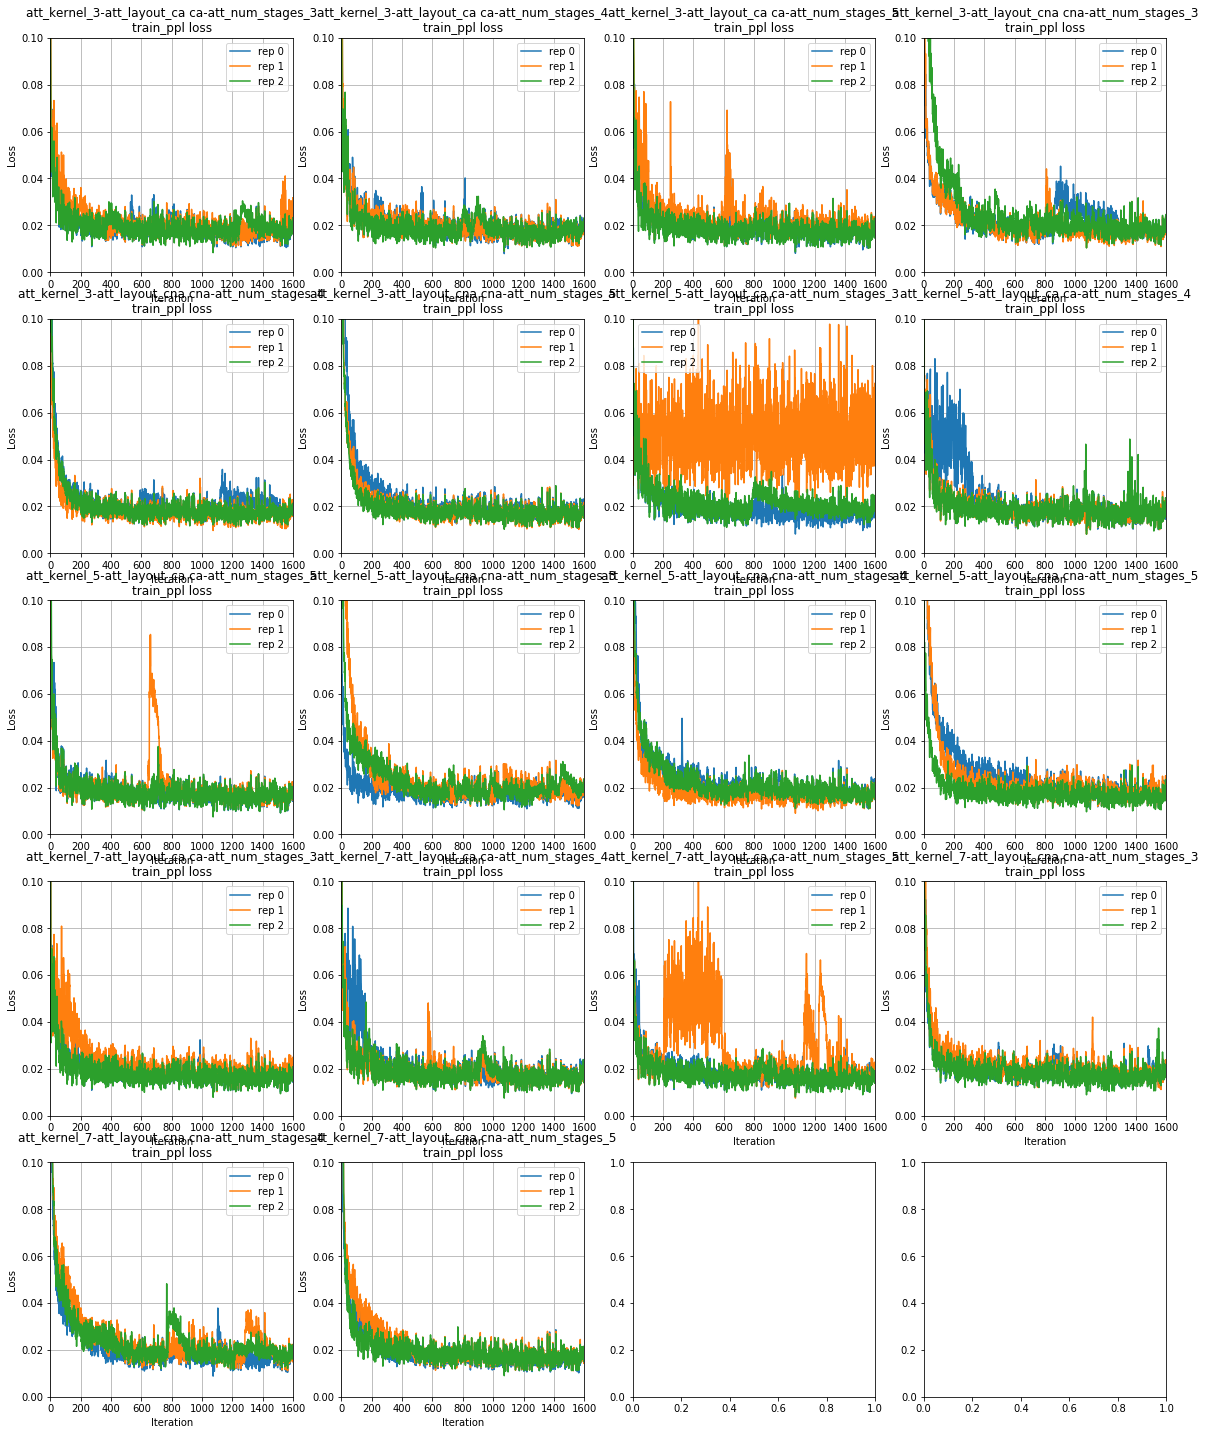

In [13]:
plot_results_by_config(res, {'train_ppl': 'loss'}, layout='square', ylim=(0, 0.1))

In [14]:
boom!

SyntaxError: invalid syntax (<ipython-input-14-d08c4e790d4a>, line 1)

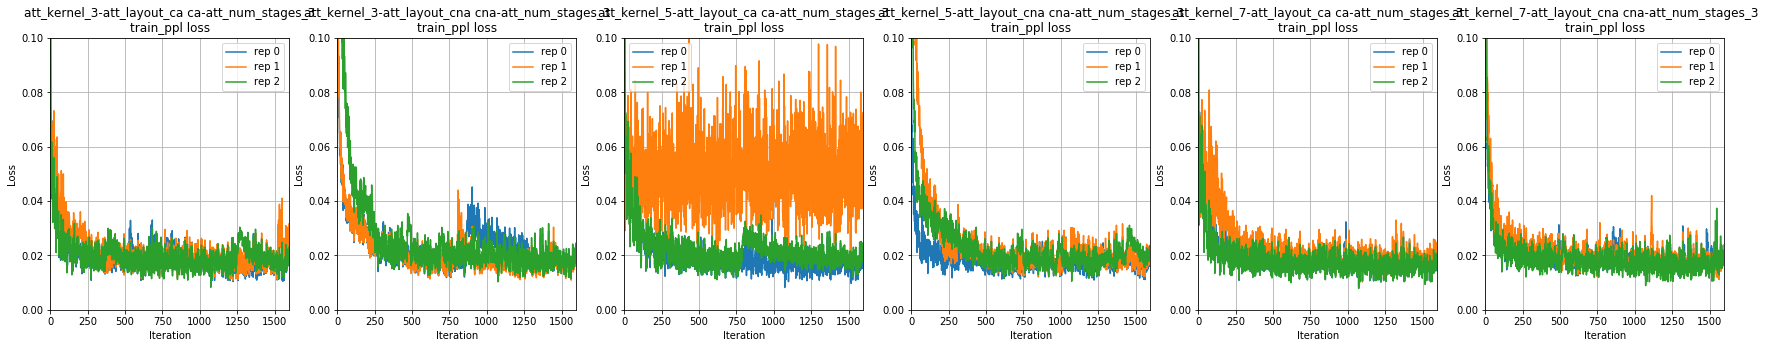

In [15]:
plot_results_by_config(res[res.config.str.contains('num_stages_3')], {'train_ppl': 'loss'}, layout='force_flat', ylim=(0, 0.1))

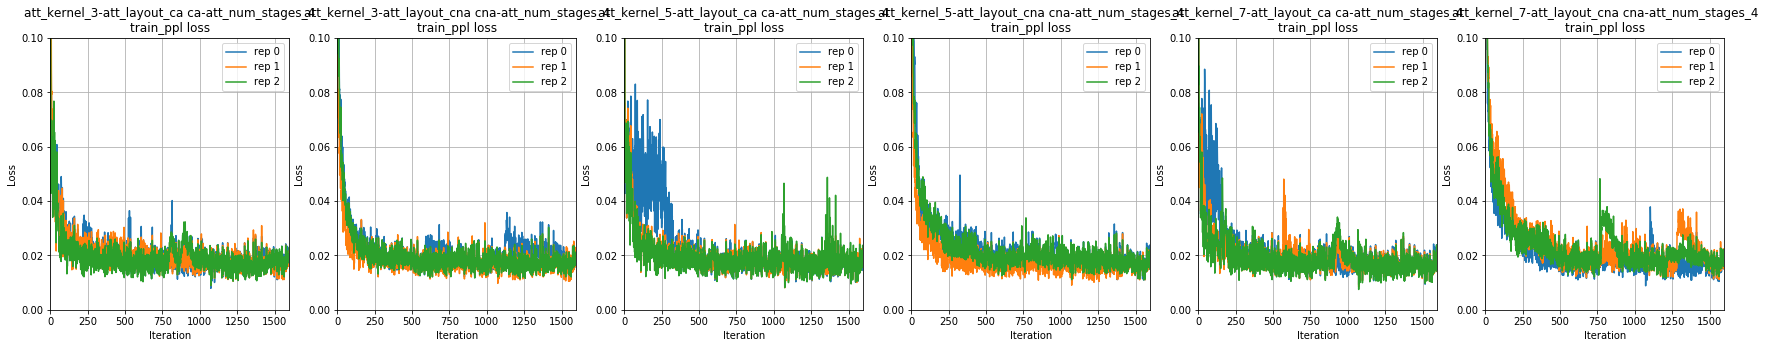

In [16]:
plot_results_by_config(res[res.config.str.contains('num_stages_4')], {'train_ppl': 'loss'}, layout='force_flat', ylim=(0, 0.1))

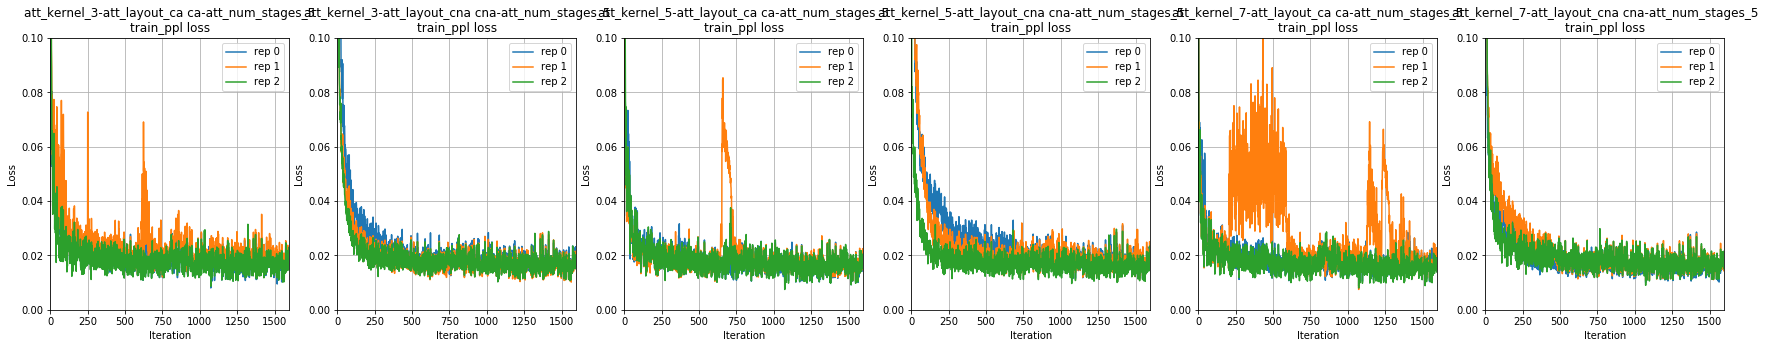

In [17]:
plot_results_by_config(res[res.config.str.contains('num_stages_5')], {'train_ppl': 'loss'}, layout='force_flat', ylim=(0, 0.1))

In [26]:
snapshots = res[(res.name == 'save_model_fn') & (res.repetition == 0)][['config', 'snapshot_path']]
snapshots.set_index('config').to_dict()

{'snapshot_path': {'att_kernel_3-att_layout_ca ca-att_num_stages_3': './my_mdl/noise_dataset_1/2019-10-23_13:17:18.615015+03:00',
  'att_kernel_3-att_layout_ca ca-att_num_stages_4': './my_mdl/noise_dataset_1/2019-10-23_13:25:51.786069+03:00',
  'att_kernel_3-att_layout_ca ca-att_num_stages_5': './my_mdl/noise_dataset_1/2019-10-23_13:34:19.494421+03:00',
  'att_kernel_3-att_layout_cna cna-att_num_stages_3': './my_mdl/noise_dataset_1/2019-10-23_14:37:34.295197+03:00',
  'att_kernel_3-att_layout_cna cna-att_num_stages_4': './my_mdl/noise_dataset_1/2019-10-23_14:47:01.953775+03:00',
  'att_kernel_3-att_layout_cna cna-att_num_stages_5': './my_mdl/noise_dataset_1/2019-10-23_14:56:20.305216+03:00',
  'att_kernel_5-att_layout_ca ca-att_num_stages_3': './my_mdl/noise_dataset_1/2019-10-23_13:43:25.872216+03:00',
  'att_kernel_5-att_layout_ca ca-att_num_stages_4': './my_mdl/noise_dataset_1/2019-10-23_13:52:12.514482+03:00',
  'att_kernel_5-att_layout_ca ca-att_num_stages_5': './my_mdl/noise_datas